In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.1 MB/s 
     |████████████████████████████████| 9.9 MB 19.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics

import datetime as dt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.api import ExponentialSmoothing

from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

import pmdarima as pmd
from pmdarima import model_selection

**Data Preparation**

In [ ]:
# Importing data
url = 'https://github.com/robertasgabrys/Forecasting/blob/main/TiffanySales.xlsx?raw=true'
df = pd.read_excel(url)
df.head()

,Date,Sales,CPI,GDP,DPI,Unemp,Interest rate
0,2005-01-01,509901,190.733333,12816.2,9187.533333,5.300000,2.496667
1,2005-04-01,526701,191.933333,12975.7,9321.833333,5.100000,2.973333
2,2005-07-01,500105,194.500000,13206.5,9472.433333,4.966667,3.460000
3,2005-10-01,858446,196.866667,13383.3,9625.300000,4.966667,4.026667
4,2006-01-01,539241,197.866667,13649.8,9890.700000,4.733333,4.480000


In [ ]:
df["Year"] = df["Date"].dt.year.astype(int)

df["Quarter"] = df["Date"].dt.month.astype(int)

df["Quarter"] = df["Quarter"].replace({1: "Q1", 4: "Q2", 7: "Q3", 10: "Q4"})

df["YearQ"] = df["Year"].astype(str).str.cat(df["Quarter"], sep=" ")

df.set_index("YearQ", inplace=True)

df = df.rename(columns={'Interest rate': 'IRate'})

df.head(5)

,Date,Sales,CPI,GDP,DPI,Unemp,IRate,Year,Quarter
YearQ,,,,,,,,,
2005 Q1,2005-01-01,509901,190.733333,12816.2,9187.533333,5.300000,2.496667,2005,Q1
2005 Q2,2005-04-01,526701,191.933333,12975.7,9321.833333,5.100000,2.973333,2005,Q2
2005 Q3,2005-07-01,500105,194.500000,13206.5,9472.433333,4.966667,3.460000,2005,Q3
2005 Q4,2005-10-01,858446,196.866667,13383.3,9625.300000,4.966667,4.026667,2005,Q4
2006 Q1,2006-01-01,539241,197.866667,13649.8,9890.700000,4.733333,4.480000,2006,Q1


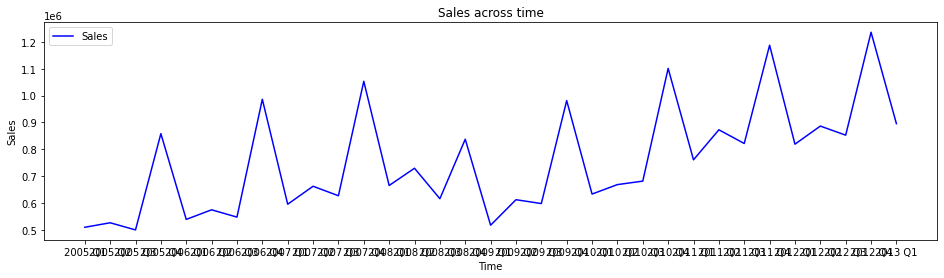

In [ ]:
# Plotting Time Series
plt.figure(figsize=(16,4))
plt.plot(df["Sales"], color='blue',label='Sales')
plt.title("Sales across time")
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

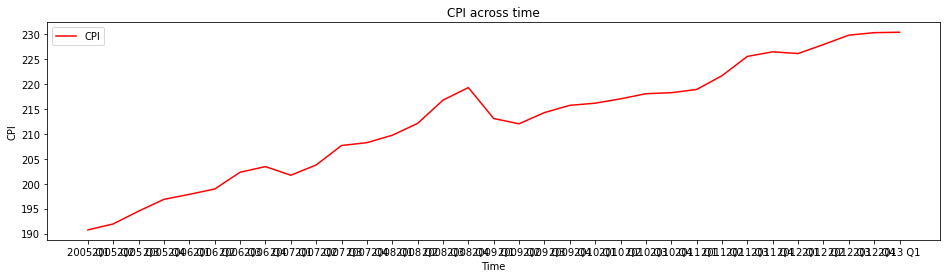

In [ ]:
# Plotting Time Series
plt.figure(figsize=(16,4))
plt.plot(df["CPI"], color='red',label='CPI')
plt.title("CPI across time")
plt.xlabel('Time')
plt.ylabel('CPI')
plt.legend()
plt.show()

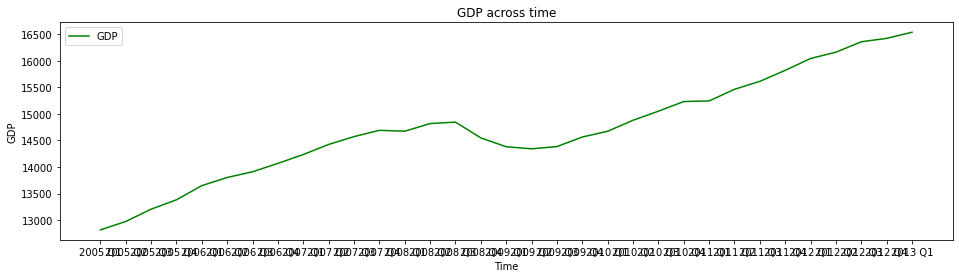

In [ ]:
# Plotting Time Series
plt.figure(figsize=(16,4))
plt.plot(df["GDP"], color='green',label='GDP')
plt.title("GDP across time")
plt.xlabel('Time')
plt.ylabel('GDP')
plt.legend()
plt.show()

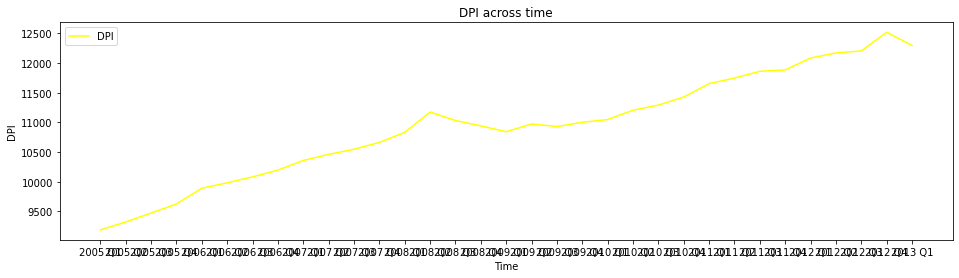

In [ ]:
# Plotting Time Series
plt.figure(figsize=(16,4))
plt.plot(df["DPI"], color='yellow',label='DPI')
plt.title("DPI across time")
plt.xlabel('Time')
plt.ylabel('DPI')
plt.legend()
plt.show()

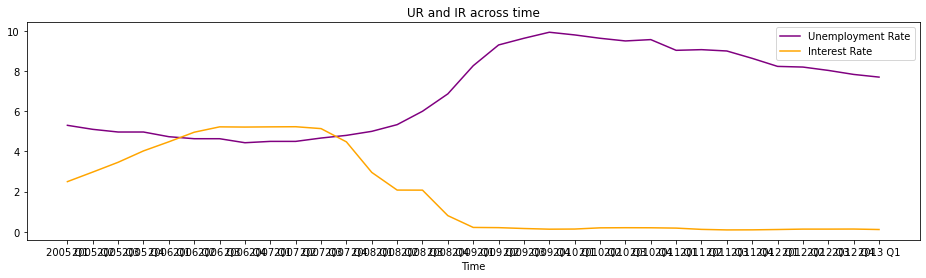

In [ ]:
# Plotting Time Series
plt.figure(figsize=(16,4))
plt.plot(df["Unemp"], color='purple',label='Unemployment Rate')
plt.plot(df["IRate"], color='orange',label='Interest Rate')
plt.title("UR and IR across time")
plt.xlabel('Time')
plt.legend()
plt.show()

In [ ]:
# Split the data into a training set and a test set
train = df.copy()
train.loc[train.index[-4:], ['Sales']] = np.nan

# Prediction column
train["Prediction"] = "Fitted values"
train.loc[-4:, "Prediction"] = "Forecast"

In [ ]:
# MAPE accuracy function
def mape(actual,predicted):
    return round(abs((actual - predicted)/actual).mean()*100,2)

def accuracy(actual,predicted,h=0):
    n_train = len(actual) - h
    accuracy_metrics = pd.DataFrame(columns=['MAPE(%)'],index=['Training set','Testing set'])
    accuracy_metrics.loc['Training set','MAPE(%)'] = mape(actual[:n_train],predicted[:n_train])
    if (h>0):
        accuracy_metrics.loc['Testing set','MAPE(%)'] = mape(actual[n_train:],predicted[n_train:])
    return accuracy_metrics

In [ ]:
# Building MAPE df with all models
MAPE_df = pd.DataFrame(columns=['Training set MAPE(%)','Testing set MAPE(%)'],index=["Model 1", "Model 2", "Model 3",
                                                                                     "Model 4", "Model 5", "Model 6",
                                                                                     "Model 7", "Model 8", "Model 9",
                                                                                     "Model 10", "Model 11", "Model 12",
                                                                                     "Model 13", "Model 14", "Model 15",])

**Model 1**

**Model 2** - regression model that captures linear trend and annual seasonality

In [ ]:
# Create Trend column
train['Trend'] = list(range(1,train.shape[0]+1))

# Model
M2 = smf.ols('Sales ~ Trend + C(Year)',data = train).fit()
print(M2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     5.728
Date:                Fri, 09 Dec 2022   Prob (F-statistic):           0.000730
Time:                        04:38:07   Log-Likelihood:                -376.05
No. Observations:                  29   AIC:                             770.1
Df Residuals:                      20   BIC:                             782.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3.097e+05   8.17e+04     

/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars


In [ ]:
train["M2"] = M2.predict(train)

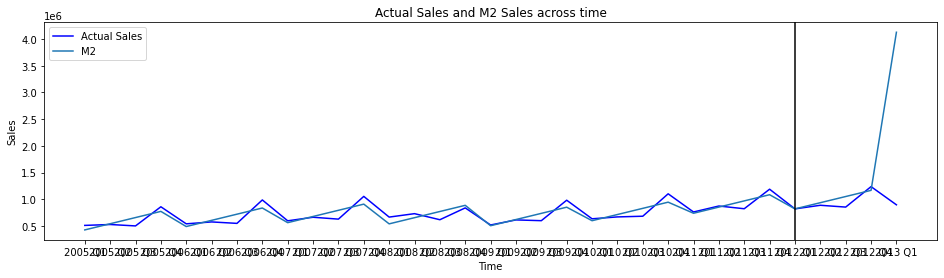

In [ ]:
# Plotting Time Series
plt.figure(figsize=(16,4))
plt.plot(df["Sales"], color='blue',label='Actual Sales')
plt.plot(train["M2"],label='M2')
plt.title("Actual Sales and M2 Sales across time")
plt.xlabel('Time')
plt.ylabel('Sales')
plt.axvline(x="2012 Q1", color="black")
plt.legend()
plt.show()

In [ ]:
# Calculate MAPE
acc = accuracy(actual=df["Sales"], predicted=train["M2"], h=4)
MAPE_df.iloc[1,0] = acc.iloc[0,0]
MAPE_df.iloc[1,1] = acc.iloc[1,0]
acc

,MAPE(%)
Training set,12.07
Testing set,98.74


**Model 3:** regression model that captures linear trend, annual seasonality and abrupt change starting 2008-04-01

In [ ]:
# Abrupt change column
train['FC'] = 0
train.loc[13:,'FC'] = 1

# Model
M3 = smf.ols('Sales ~ Trend + C(Year) + FC',data = train).fit()
print(M3.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     5.402
Date:                Fri, 09 Dec 2022   Prob (F-statistic):           0.000984
Time:                        04:38:08   Log-Likelihood:                -374.91
No. Observations:                  29   AIC:                             769.8
Df Residuals:                      19   BIC:                             783.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2.899e+05   8.21e+04     

In [ ]:
train["M3"] = M3.predict(train)

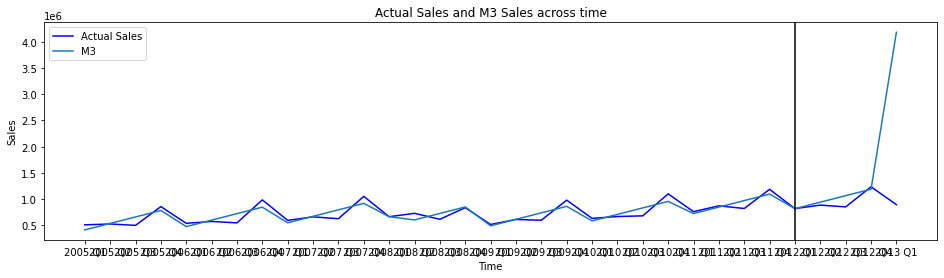

In [ ]:
# Plotting Time Series
plt.figure(figsize=(16,4))
plt.plot(df["Sales"], color='blue',label='Actual Sales')
plt.plot(train["M3"],label='M3')
plt.title("Actual Sales and M3 Sales across time")
plt.xlabel('Time')
plt.ylabel('Sales')
plt.axvline(x="2012 Q1", color="black")
plt.legend()
plt.show()

In [ ]:
# Calculate MAPE
acc = accuracy(actual=df["Sales"], predicted=train["M3"], h=4)
MAPE_df.iloc[2,0] = acc.iloc[0,0]
MAPE_df.iloc[2,1] = acc.iloc[1,0]
acc

,MAPE(%)
Training set,11.49
Testing set,100.54


**Model 4:** regression model that captures linear trend, annual seasonality and temporary abrupt change starting 2008-04-01 and ending 2009-04-01

In [ ]:
# Abrupt change column
train['FC2'] = 0
train.loc[13:17,'FC2'] = 1

# Model
M4 = smf.ols('Sales ~ Trend + C(Year) + FC2',data = train).fit()
print(M4.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     5.032
Date:                Fri, 09 Dec 2022   Prob (F-statistic):            0.00149
Time:                        04:38:08   Log-Likelihood:                -375.64
No. Observations:                  29   AIC:                             771.3
Df Residuals:                      19   BIC:                             785.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3.097e+05   8.26e+04     

In [ ]:
train["M4"] = M4.predict(train)

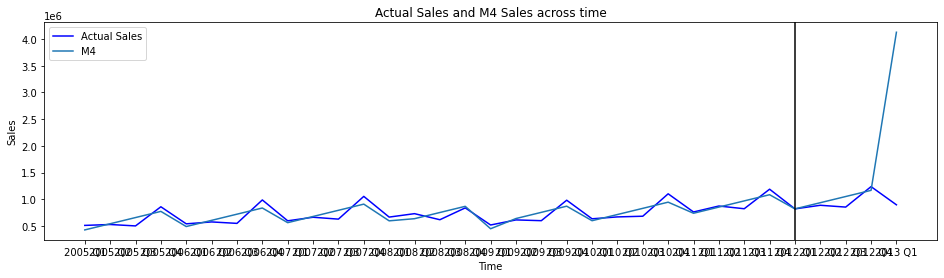

In [ ]:
# Plotting Time Series
plt.figure(figsize=(16,4))
plt.plot(df["Sales"], color='blue',label='Actual Sales')
plt.plot(train["M4"],label='M4')
plt.title("Actual Sales and M4 Sales across time")
plt.xlabel('Time')
plt.ylabel('Sales')
plt.axvline(x="2012 Q1", color="black")
plt.legend()
plt.show()

In [ ]:
# Calculate MAPE
acc = accuracy(actual=df["Sales"], predicted=train["M4"], h=4)
MAPE_df.iloc[3,0] = acc.iloc[0,0]
MAPE_df.iloc[3,1] = acc.iloc[1,0]
acc

,MAPE(%)
Training set,12.21
Testing set,98.74


**Model 5:** Model 3 + Ramp starting 2008-04-01

In [ ]:
# Ramp variable
train['Ramp'] = 0
train.loc[13:,'Ramp'] = list(range(len(train.iloc[12:])))[1:]

# Model
M5 = smf.ols('Sales ~ Trend + C(Year) + FC + Ramp',data = train).fit()
print(M5.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     4.607
Date:                Fri, 09 Dec 2022   Prob (F-statistic):            0.00245
Time:                        04:38:09   Log-Likelihood:                -374.91
No. Observations:                  29   AIC:                             771.8
Df Residuals:                      18   BIC:                             786.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2.929e+05   1.03e+05     

In [ ]:
train["M5"] = M5.predict(train)

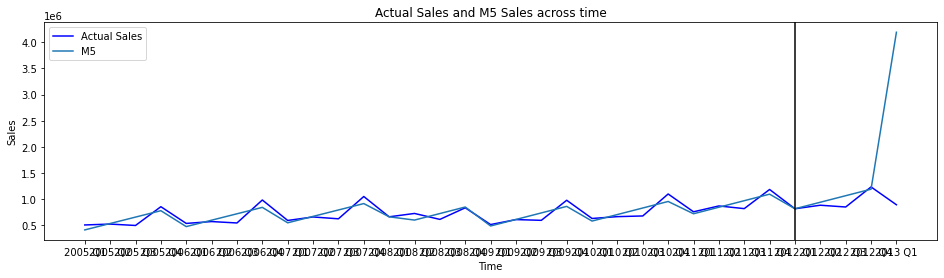

In [ ]:
# Plotting Time Series
plt.figure(figsize=(16,4))
plt.plot(df["Sales"], color='blue',label='Actual Sales')
plt.plot(train["M5"],label='M5')
plt.title("Actual Sales and M5 Sales across time")
plt.xlabel('Time')
plt.ylabel('Sales')
plt.axvline(x="2012 Q1", color="black")
plt.legend()
plt.show()

In [ ]:
# Calculate MAPE
acc = accuracy(actual=df["Sales"], predicted=train["M5"], h=4)
MAPE_df.iloc[4,0] = acc.iloc[0,0]
MAPE_df.iloc[4,1] = acc.iloc[1,0]
acc

,MAPE(%)
Training set,11.5
Testing set,100.75


**Model 6:** Model 4 + Ramp starting 2008-04-01

In [ ]:
# Model
M6 = smf.ols('Sales ~ Trend + C(Year) + FC2 + Ramp',data = train).fit()
print(M6.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     4.315
Date:                Fri, 09 Dec 2022   Prob (F-statistic):            0.00349
Time:                        04:38:09   Log-Likelihood:                -375.59
No. Observations:                  29   AIC:                             773.2
Df Residuals:                      18   BIC:                             788.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2.929e+05   1.06e+05     

In [ ]:
train["M6"] = M6.predict(train)

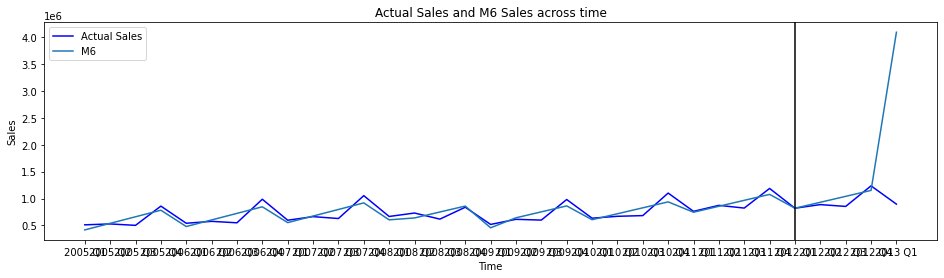

In [ ]:
# Plotting Time Series
plt.figure(figsize=(16,4))
plt.plot(df["Sales"], color='blue',label='Actual Sales')
plt.plot(train["M6"],label='M6')
plt.title("Actual Sales and M6 Sales across time")
plt.xlabel('Time')
plt.ylabel('Sales')
plt.axvline(x="2012 Q1", color="black")
plt.legend()
plt.show()

In [ ]:
# Calculate MAPE
acc = accuracy(actual=df["Sales"], predicted=train["M6"], h=4)
MAPE_df.iloc[5,0] = acc.iloc[0,0]
MAPE_df.iloc[5,1] = acc.iloc[1,0]
acc

,MAPE(%)
Training set,12.12
Testing set,97.77


**Model 7:** Model 5 + Ramp starting 2008-04-01

(crossed out - same as M5)

**Model 8:** Model 4 + Ramp 1 starting 2008-04-01 + Ramp 2 starting 2009-07-01

In [ ]:
# Second Ramp
train['Ramp2'] = 0
train.loc[18:,'Ramp2'] = list(range(len(train.iloc[17:])))[1:]

In [ ]:
# Model
M8 = smf.ols('Sales ~ Trend + C(Year) + FC2 + Ramp + Ramp2',data = train).fit()
print(M8.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     4.238
Date:                Fri, 09 Dec 2022   Prob (F-statistic):            0.00396
Time:                        04:38:10   Log-Likelihood:                -374.18
No. Observations:                  29   AIC:                             772.4
Df Residuals:                      17   BIC:                             788.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2.929e+05   1.04e+05     

In [ ]:
train["M8"] = M8.predict(train)

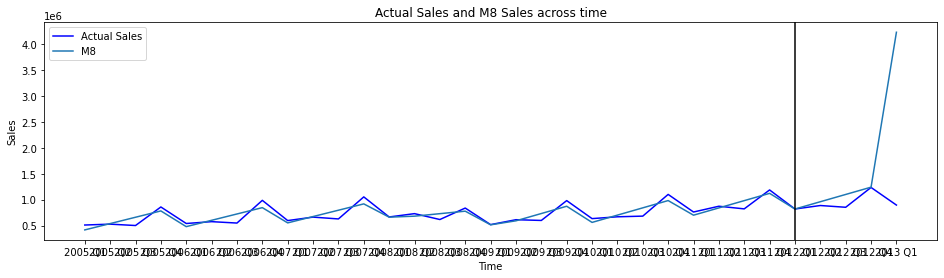

In [ ]:
# Plotting Time Series
plt.figure(figsize=(16,4))
plt.plot(df["Sales"], color='blue',label='Actual Sales')
plt.plot(train["M8"],label='M8')
plt.title("Actual Sales and M8 Sales across time")
plt.xlabel('Time')
plt.ylabel('Sales')
plt.axvline(x="2012 Q1", color="black")
plt.legend()
plt.show()

In [ ]:
# Calculate MAPE
acc = accuracy(actual=df["Sales"], predicted=train["M8"], h=4)
MAPE_df.iloc[7,0] = acc.iloc[0,0]
MAPE_df.iloc[7,1] = acc.iloc[1,0]
acc

,MAPE(%)
Training set,11.38
Testing set,102.63


**Model 9:** Model 5 + Ramp 1 starting 2008-04-01 + Ramp 2 starting 2009-07-01

In [ ]:
# Model
M9 = smf.ols('Sales ~ Trend + C(Year) + FC + Ramp + Ramp2',data = train).fit()
print(M9.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     4.236
Date:                Fri, 09 Dec 2022   Prob (F-statistic):            0.00396
Time:                        04:38:10   Log-Likelihood:                -374.19
No. Observations:                  29   AIC:                             772.4
Df Residuals:                      17   BIC:                             788.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2.929e+05   1.04e+05     

In [ ]:
train["M9"] = M9.predict(train)

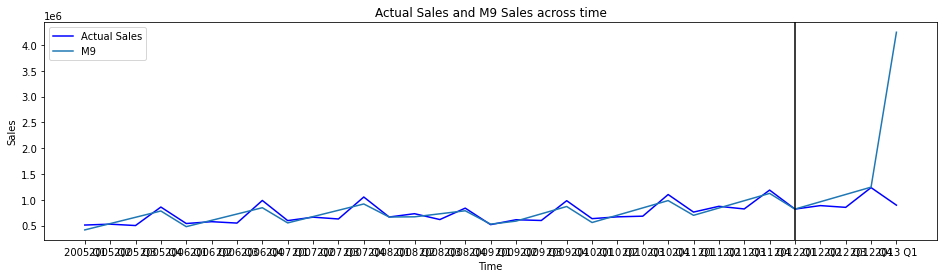

In [ ]:
# Plotting Time Series
plt.figure(figsize=(16,4))
plt.plot(df["Sales"], color='blue',label='Actual Sales')
plt.plot(train["M9"],label='M9')
plt.title("Actual Sales and M9 Sales across time")
plt.xlabel('Time')
plt.ylabel('Sales')
plt.axvline(x="2012 Q1", color="black")
plt.legend()
plt.show()

In [ ]:
# Calculate MAPE
acc = accuracy(actual=df["Sales"], predicted=train["M9"], h=4)
MAPE_df.iloc[8,0] = acc.iloc[0,0]
MAPE_df.iloc[8,1] = acc.iloc[1,0]
acc

,MAPE(%)
Training set,11.44
Testing set,103.17


**Model 10:** Exponential smoothing

In [ ]:
# Creating Exponential Smoothing model
M10a = ExponentialSmoothing(train['Sales'].dropna(),trend = 'add',seasonal='mul',seasonal_periods=4).fit()
print(M10a.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.


                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   29
Model:             ExponentialSmoothing   SSE                    96020561987.442
Optimized:                         True   AIC                            651.695
Trend:                         Additive   BIC                            662.634
Seasonal:                Multiplicative   AICC                           663.918
Seasonal Periods:                     4   Date:                 Fri, 09 Dec 2022
Box-Cox:                          False   Time:                         04:38:11
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9242857                alpha                 True
smoothing_trend          

In [ ]:
# Creating Exponential Smoothing model
M10b = ExponentialSmoothing(train['Sales'].dropna(),trend = 'add',seasonal='add',seasonal_periods=4).fit()
print(M10b.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   29
Model:             ExponentialSmoothing   SSE                    57534562811.659
Optimized:                         True   AIC                            636.842
Trend:                         Additive   BIC                            647.781
Seasonal:                      Additive   AICC                           649.065
Seasonal Periods:                     4   Date:                 Fri, 09 Dec 2022
Box-Cox:                          False   Time:                         04:38:12
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9950000                alpha                 True
smoothing_trend          

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.


In [ ]:
# Creating Exponential Smoothing model
M10c = ExponentialSmoothing(train['Sales'].dropna(),seasonal='add',seasonal_periods=4).fit()
print(M10c.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.


                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   29
Model:             ExponentialSmoothing   SSE                    60511249402.702
Optimized:                         True   AIC                            634.305
Trend:                             None   BIC                            642.509
Seasonal:                      Additive   AICC                           641.505
Seasonal Periods:                     4   Date:                 Fri, 09 Dec 2022
Box-Cox:                          False   Time:                         04:38:12
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9950000                alpha                 True
smoothing_seasonal       

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.


In [ ]:
# Saving fitted values and forecasts for all three exp. smoothing models
train.loc[:-4, "M10a"] = M10a.fittedvalues
f10a = M10a.forecast(4)
train.loc[29:, "M10a"] = list(f10a)

train.loc[:-4, "M10b"] = M10b.fittedvalues
f10b = M10b.forecast(4)
train.loc[29:, "M10b"] = list(f10b)

train.loc[:-4, "M10c"] = M10c.fittedvalues
f10c = M10c.forecast(4)
train.loc[29:, "M10c"] = list(f10c)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


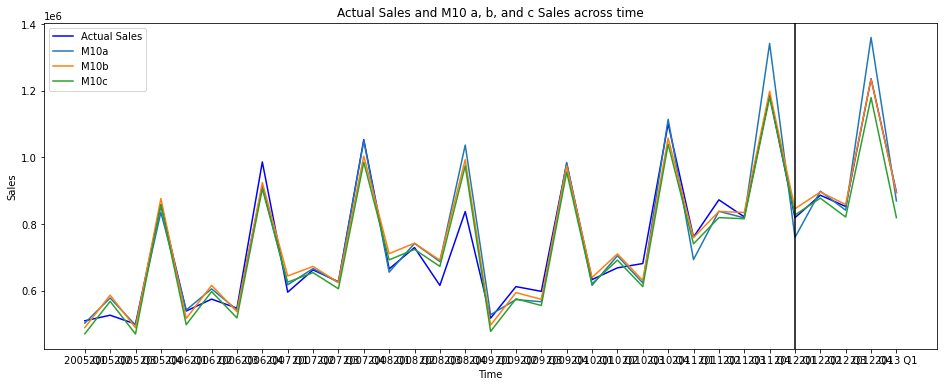

In [ ]:
# Plotting Time Series
plt.figure(figsize=(16,6))
plt.plot(df["Sales"], color='blue',label='Actual Sales')
plt.plot(train["M10a"],label='M10a')
plt.plot(train["M10b"],label='M10b')
plt.plot(train["M10c"],label='M10c')
plt.title("Actual Sales and M10 a, b, and c Sales across time")
plt.xlabel('Time')
plt.ylabel('Sales')
plt.axvline(x="2012 Q1", color="black")
plt.legend()
plt.show()

In [ ]:
# M10b (add trend and add seasonality) seems like the closest to Actual sales in test period.
# However, M10c (no trend and add seasonality) has a lower AIC score.
# I chose M10b in the end

In [ ]:
# Calculate MAPE
acc = accuracy(actual=df["Sales"], predicted=train["M10b"], h=4)
MAPE_df.iloc[9,0] = acc.iloc[0,0]
MAPE_df.iloc[9,1] = acc.iloc[1,0]
acc

,MAPE(%)
Training set,4.61
Testing set,0.51


**Model 11:** auto arima model: max p, q, P, Q ≤ 2, d+D ≤ 2

In [ ]:
train_auto = train["Sales"].dropna()

# Buliding auto_arima
M11 = pmd.auto_arima(train_auto, start_p=0, d=None, start_q=0, max_p=2, max_d=2, max_q=2, 
                   start_P=0, D=None, start_Q=0, max_P=2, max_D=2, max_Q=2, max_order=10, m=4,
                   trace = True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=646.708, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=655.384, Time=0.24 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=648.460, Time=0.20 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=651.914, Time=0.06 sec
 ARIMA(0,0,0)(1,1,0)[4] intercept   : AIC=648.687, Time=0.11 sec
 ARIMA(0,0,0)(0,1,1)[4] intercept   : AIC=648.681, Time=0.13 sec
 ARIMA(0,0,0)(1,1,1)[4] intercept   : AIC=650.675, Time=0.31 sec
 ARIMA(1,0,0)(0,1,0)[4] intercept   : AIC=653.386, Time=0.05 sec
 ARIMA(0,0,1)(0,1,0)[4] intercept   : AIC=646.478, Time=0.11 sec
 ARIMA(0,0,1)(1,1,0)[4] intercept   : AIC=648.472, Time=0.46 sec
 ARIMA(0,0,1)(1,1,1)[4] intercept   : AIC=649.725, Time=0.56 sec
 ARIMA(1,0,1)(0,1,0)[4] intercept   : AIC=654.305, Time=0.21 sec
 ARIMA(0,0,2)(0,1,0)[4] intercept   : AIC=650.437, Time=0.09 sec
 ARIMA(1,0,2)(0,1,0)[4] intercept   : AIC=653.166, Time=0.39 sec
 ARIMA(0,0,1)(0,1,0)[4]             : AIC=648.8

In [ ]:
M11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   29
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 4)   Log Likelihood                -320.239
Date:                            Fri, 09 Dec 2022   AIC                            646.478
Time:                                    04:38:16   BIC                            650.134
Sample:                                         0   HQIC                           647.492
                                             - 29                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.169e+04    1.8e+04      2.315      0.021    6400.484     7.7e+04
ma.L1          0.1663      0.064      2.585      0.010       0.040       0.292
sigma2       6.76e+09      0.144   4.68e+10      0.000    6.76e+09    6.76e+09
===================================================================================
Ljung-Box (L1) (Q):                   8.78   Jarque-Bera (JB):                 6.79
Prob(Q):                              0.00   Prob(JB):                         0.03
Heteroskedasticity (H):               1.35   Skew:                            -1.15
Prob(H) (two-sided):                  0.68   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.05e+33. Standard errors may be unstable.
"""

In [ ]:
# Saving fitted values and forecasts
train["M11"] = M11.predict_in_sample()
auto_pred = list(M11.predict(n_periods= 4,dynamic=True))
train.loc[29:, "M11"] = auto_pred

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


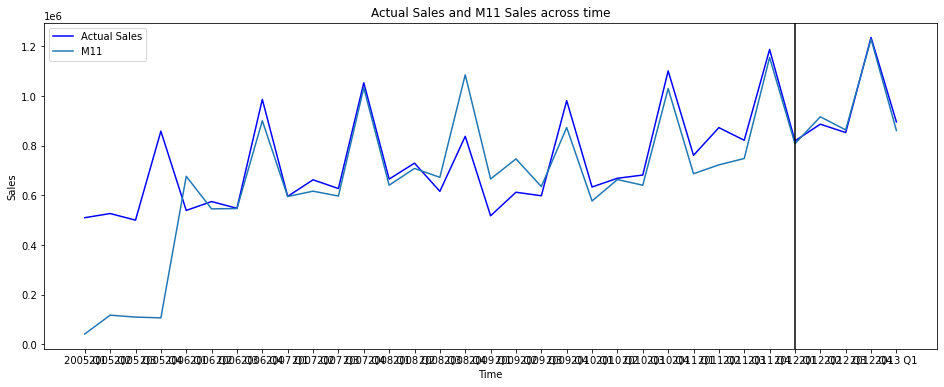

In [ ]:
# Plotting Time Series
plt.figure(figsize=(16,6))
plt.plot(df["Sales"], color='blue',label='Actual Sales')
plt.plot(train["M11"],label='M11')
plt.title("Actual Sales and M11 Sales across time")
plt.xlabel('Time')
plt.ylabel('Sales')
plt.axvline(x="2012 Q1", color="black")
plt.legend()
plt.show()

In [ ]:
# Calculate MAPE
acc = accuracy(actual=df["Sales"], predicted=train["M11"], h=4)
MAPE_df.iloc[10,0] = acc.iloc[0,0]
MAPE_df.iloc[10,1] = acc.iloc[1,0]
acc

,MAPE(%)
Training set,19.44
Testing set,2.25


**Model 12:** select the most accurate model among Models  2 – 9 and dump its features into auto arima

In [ ]:
MAPE_df

,Training set MAPE(%),Testing set MAPE(%)
Model 1,NaN,NaN
Model 2,12.07,98.74
Model 3,11.49,100.54
Model 4,12.21,98.74
Model 5,11.5,100.75
Model 6,12.12,97.77
Model 7,NaN,NaN
Model 8,11.38,102.63
Model 9,11.44,103.17
Model 10,4.61,0.51


In [ ]:
# Most accurate model from 2-8 is M6

exog = pd.DataFrame({'x1': train["Trend"],
                     'x2': train["Year"],
                     'x3': train["FC2"],
                     'x4': train["Ramp"]})

exog_train = exog.iloc[:29]

# Buliding auto_arima
M12 = pmd.auto_arima(train_auto, X=exog_train, start_p=0, d=None, start_q=0, max_p=2, max_d=2, max_q=2, 
                   start_P=0, D=None, start_Q=0, max_P=2, max_D=2, max_Q=2, max_order=10, m=4,
                   trace = True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=789.539, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=774.480, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=779.193, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=857.191, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=788.811, Time=0.29 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=776.379, Time=0.28 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=776.150, Time=0.36 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=779.302, Time=0.42 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=777.910, Time=1.08 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=774.494, Time=0.43 sec
 ARIMA(2,0,0)(1,0,0)[4] intercept   : AIC=776.872, Time=0.30 sec
 ARIMA(1,0,1)(1,0,0)[4] intercept   : AIC=776.205, Time=0.52 sec
 ARIMA(0,0,1)(1,0,0)[4] intercept   : AIC=774.565, Time=0.55 sec
 ARIMA(2,0,1)(1,0,0)[4] intercept   : AIC=774.301, Time=0.61 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=792.5

In [ ]:
M12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   29
Model:             SARIMAX(1, 0, 2)x(1, 0, [], 4)   Log Likelihood                -375.108
Date:                            Fri, 09 Dec 2022   AIC                            768.215
Time:                                    04:38:51   BIC                            780.521
Sample:                                         0   HQIC                           772.069
                                             - 29                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            1.4e+04   3.98e+04      0.352      0.725    -6.4e+04     9.2e+04
x2           281.6091    222.895      1.263      0.206    -155.258     718.476
x3          -7.97e+04   8.64e+04     -0.923      0.356   -2.49e+05    8.96e+04
x4         -4457.9854   5.81e+04     -0.077      0.939   -1.18e+05    1.09e+05
ar.L1         -0.9925      0.247     -4.024      0.000      -1.476      -0.509
ma.L1          1.4075      0.984      1.431      0.152      -0.520       3.335
ma.L2          0.4379      1.012      0.433      0.665      -1.546       2.422
ar.S.L4        0.6999      0.472      1.482      0.138      -0.226       1.625
sigma2       1.68e+10      0.108   1.55e+11      0.000    1.68e+10    1.68e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 1.84
Prob(Q):                              0.76   Prob(JB):                         0.40
Heteroskedasticity (H):               0.65   Skew:                            -0.37
Prob(H) (two-sided):                  0.50   Kurtosis:                         3.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.47e+29. Standard errors may be unstable.
"""

In [ ]:
# Saving fitted values and forecasts
train["M12"] = M12.predict_in_sample(X=exog_train)
auto_pred = list(M12.predict(n_periods= 4,dynamic=True, X=exog.iloc[29:]))
train.loc[29:, "M12"] = auto_pred

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


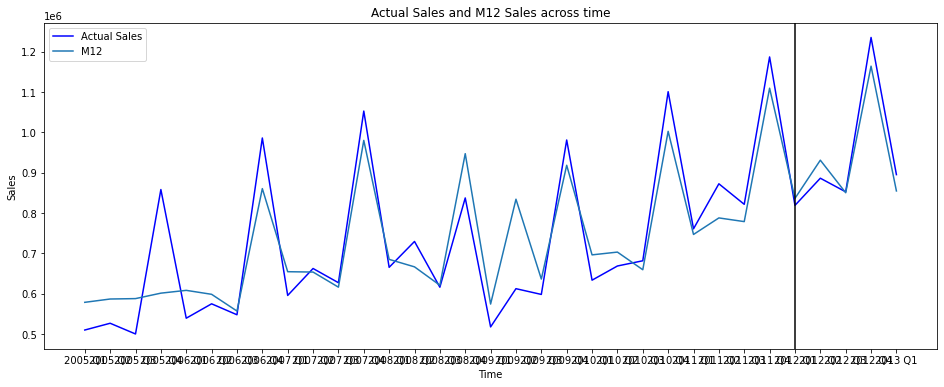

In [ ]:
# Plotting Time Series
plt.figure(figsize=(16,6))
plt.plot(df["Sales"], color='blue',label='Actual Sales')
plt.plot(train["M12"],label='M12')
plt.title("Actual Sales and M12 Sales across time")
plt.xlabel('Time')
plt.ylabel('Sales')
plt.axvline(x="2012 Q1", color="black")
plt.legend()
plt.show()

In [ ]:
# Calculate MAPE
acc = accuracy(actual=df["Sales"], predicted=train["M12"], h=4)
MAPE_df.iloc[11,0] = acc.iloc[0,0]
MAPE_df.iloc[11,1] = acc.iloc[1,0]
acc

,MAPE(%)
Training set,9.03
Testing set,3.9


**Model 13:** regression that predicts sales from exogenous variables, CPI,GDP, DPI, Unemp, Interest rate

In [ ]:
# Buliding loop to get all possible combinations
reg_str = "Sales ~ "
plus = " + "

exvar = ["CPI", "GDP", "DPI", "Unemp", "IRate"]
combos = []

for n in exvar:
  combostr = reg_str + n
  combos.append(combostr)

# Sorry didn't have time to figure out how to use loop so I used online combination calculator
combos.append((reg_str + exvar[0] + plus + exvar[1]))
combos.append((reg_str + exvar[0] + plus +  exvar[2]))
combos.append((reg_str + exvar[0] + plus +  exvar[3]))
combos.append((reg_str + exvar[0] + plus +  exvar[4]))
combos.append((reg_str + exvar[1] + plus +  exvar[2]))
combos.append((reg_str + exvar[1] + plus +  exvar[3]))
combos.append((reg_str + exvar[1] + plus +  exvar[4]))
combos.append((reg_str + exvar[2] + plus +  exvar[3]))
combos.append((reg_str + exvar[2] + plus +  exvar[4]))
combos.append((reg_str + exvar[3] + plus +  exvar[4]))
combos.append((reg_str + exvar[0] + plus +  exvar[1] + plus +  exvar[2]))
combos.append((reg_str + exvar[0] + plus +  exvar[1] + plus +  exvar[3]))
combos.append((reg_str + exvar[0] + plus +  exvar[1] + plus +  exvar[4]))
combos.append((reg_str + exvar[0] + plus +  exvar[2] + plus +  exvar[3]))
combos.append((reg_str + exvar[0] + plus +  exvar[2] + plus +  exvar[4]))
combos.append((reg_str + exvar[0] + plus +  exvar[3] + plus +  exvar[4]))
combos.append((reg_str + exvar[1] + plus +  exvar[2] + plus +  exvar[3]))
combos.append((reg_str + exvar[1] + plus +  exvar[2] + plus +  exvar[4]))
combos.append((reg_str + exvar[1] + plus +  exvar[3] + plus +  exvar[4]))
combos.append((reg_str + exvar[2] + plus +  exvar[3] + plus +  exvar[4]))
combos.append((reg_str + exvar[0] + plus + exvar[1] + plus + exvar[2] + plus + exvar[3]))
combos.append((reg_str + exvar[0] + plus + exvar[1] + plus + exvar[2] + plus + exvar[4]))
combos.append((reg_str + exvar[0] + plus + exvar[1] + plus + exvar[3] + plus + exvar[4]))
combos.append((reg_str + exvar[0] + plus + exvar[2] + plus + exvar[3] + plus + exvar[4]))
combos.append((reg_str + exvar[1] + plus + exvar[2] + plus + exvar[3] + plus + exvar[4]))
combos.append((reg_str + exvar[0] + plus + exvar[1] + plus + exvar[2] + plus + exvar[3] + plus + exvar[4]))

In [ ]:
modellist = []
for n in list(range(1, 32)):
  modstr = "M13_" + str(n)
  modellist.append(modstr)

In [ ]:
combos

['Sales ~ CPI',
 'Sales ~ GDP',
 'Sales ~ DPI',
 'Sales ~ Unemp',
 'Sales ~ IRate',
 'Sales ~ CPI + GDP',
 'Sales ~ CPI + DPI',
 'Sales ~ CPI + Unemp',
 'Sales ~ CPI + IRate',
 'Sales ~ GDP + DPI',
 'Sales ~ GDP + Unemp',
 'Sales ~ GDP + IRate',
 'Sales ~ DPI + Unemp',
 'Sales ~ DPI + IRate',
 'Sales ~ Unemp + IRate',
 'Sales ~ CPI + GDP + DPI',
 'Sales ~ CPI + GDP + Unemp',
 'Sales ~ CPI + GDP + IRate',
 'Sales ~ CPI + DPI + Unemp',
 'Sales ~ CPI + DPI + IRate',
 'Sales ~ CPI + Unemp + IRate',
 'Sales ~ GDP + DPI + Unemp',
 'Sales ~ GDP + DPI + IRate',
 'Sales ~ GDP + Unemp + IRate',
 'Sales ~ DPI + Unemp + IRate',
 'Sales ~ CPI + GDP + DPI + Unemp',
 'Sales ~ CPI + GDP + DPI + IRate',
 'Sales ~ CPI + GDP + Unemp + IRate',
 'Sales ~ CPI + DPI + Unemp + IRate',
 'Sales ~ GDP + DPI + Unemp + IRate',
 'Sales ~ CPI + GDP + DPI + Unemp + IRate']

In [ ]:
for n in list(range(0, 31)):
  modellist[n] = smf.ols(combos[n],data = train).fit()
  m13pred = list(modellist[n].predict(train))
  acc = accuracy(actual=df["Sales"], predicted=m13pred, h=4)
  print(n+1)
  print(acc)

1
             MAPE(%)
Training set   16.33
Testing set     9.22
2
             MAPE(%)
Training set   16.47
Testing set    13.52
3
             MAPE(%)
Training set   16.98
Testing set     8.66
4
             MAPE(%)
Training set   20.14
Testing set    20.31
5
             MAPE(%)
Training set   20.02
Testing set    18.18
6
             MAPE(%)
Training set   16.61
Testing set    14.06
7
             MAPE(%)
Training set   16.38
Testing set     9.21
8
             MAPE(%)
Training set   16.08
Testing set    11.87
9
             MAPE(%)
Training set   16.82
Testing set    10.93
10
             MAPE(%)
Training set   16.21
Testing set    19.31
11
             MAPE(%)
Training set   16.61
Testing set    14.29
12
             MAPE(%)
Training set   16.88
Testing set    13.99
13
             MAPE(%)
Training set    16.9
Testing set    10.14
14
             MAPE(%)
Training set   17.34
Testing set      9.4
15
             MAPE(%)
Training set   20.38
Testing set    21.72
16
             MAP

In [ ]:
#M13_25 has lowest MAPE (8.63) ->  'Sales ~ DPI + Unemp + IRate'
M13 = smf.ols('Sales ~ DPI + Unemp + IRate',data = train).fit()
M13.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     3.381
Date:                Fri, 09 Dec 2022   Prob (F-statistic):             0.0339
Time:                        04:38:52   Log-Likelihood:                -388.38
No. Observations:                  29   AIC:                             784.8
Df Residuals:                      25   BIC:                             790.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.107e+06   6.93e+05     -1.596      0.123   -2.54e+06    3.21e+05
DPI          158.1458     59.611      2.653      0.014      35.375     280.916
Unemp       1.047e+04    4.2e+04      0.249      0.805   -7.61e+04     9.7e+04
IRate       2.862e+04   4.28e+04      0.669      0.509   -5.94e+04    1.17e+05
==============================================================================
Omnibus:                        5.684   Durbin-Watson:                   2.692
Prob(Omnibus):                  0.058   Jarque-Bera (JB):                5.326
Skew:                           1.018   Prob(JB):                       0.0697
Kurtosis:                       2.491   Cond. No.                     2.36e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

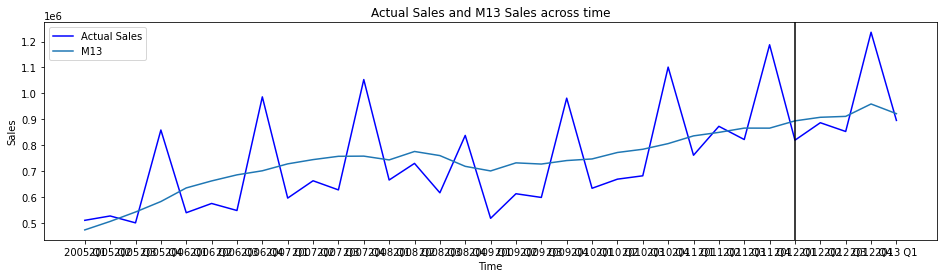

In [ ]:
train["M13"] = M13.predict(train)

# Plotting Time Series
plt.figure(figsize=(16,4))
plt.plot(df["Sales"], color='blue',label='Actual Sales')
plt.plot(train["M13"],label='M13')
plt.title("Actual Sales and M13 Sales across time")
plt.xlabel('Time')
plt.ylabel('Sales')
plt.axvline(x="2012 Q1", color="black")
plt.legend()
plt.show()

In [ ]:
# Calculate MAPE
acc = accuracy(actual=df["Sales"], predicted=train["M13"], h=4)
MAPE_df.iloc[12,0] = acc.iloc[0,0]
MAPE_df.iloc[12,1] = acc.iloc[1,0]
acc

,MAPE(%)
Training set,17.5
Testing set,8.63


**Model 14:** dump exogenous variables that you identified in previous question into auto arima

In [ ]:
exog = pd.DataFrame({'x1': train["DPI"],
                     'x2': train["Unemp"],
                     'x3': train["IRate"]})

exog_train = exog.iloc[:29]

# Buliding auto_arima
M14 = pmd.auto_arima(train_auto, X=exog_train, start_p=0, d=None, start_q=0, max_p=2, max_d=2, max_q=2, 
                   start_P=0, D=None, start_Q=0, max_P=2, max_D=2, max_Q=2, max_order=10, m=4,
                   trace = True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=640.513, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=630.799, Time=0.32 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=631.274, Time=0.20 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=695.158, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[4] intercept   : AIC=629.110, Time=0.12 sec
 ARIMA(1,0,0)(0,1,1)[4] intercept   : AIC=630.585, Time=0.27 sec
 ARIMA(1,0,0)(1,1,1)[4] intercept   : AIC=632.115, Time=0.56 sec
 ARIMA(2,0,0)(0,1,0)[4] intercept   : AIC=629.993, Time=0.17 sec
 ARIMA(1,0,1)(0,1,0)[4] intercept   : AIC=629.891, Time=0.21 sec
 ARIMA(0,0,1)(0,1,0)[4] intercept   : AIC=629.988, Time=0.09 sec
 ARIMA(2,0,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(0,1,0)[4]             : AIC=628.318, Time=0.11 sec
 ARIMA(1,0,0)(1,1,0)[4]             : AIC=629.908, Time=0.22 sec
 ARIMA(1,0,0)(0,1,1)[4]             : AIC=629.611, Time=0.23 sec
 ARIMA(1,0,0)(1,1,1)[4]             : AIC=629.855, 

In [ ]:
M14.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   29
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 4)   Log Likelihood                -309.159
Date:                           Fri, 09 Dec 2022   AIC                            628.318
Time:                                   04:38:57   BIC                            634.412
Sample:                                        0   HQIC                           630.008
                                            - 29                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            97.8838     37.608      2.603      0.009      24.173     171.595
x2         -1822.2722   1.81e+04     -0.101      0.920   -3.72e+04    3.36e+04
x3          2.153e+04    1.4e+04      1.533      0.125   -5993.979    4.91e+04
ar.L1          0.6186      0.270      2.290      0.022       0.089       1.148
sigma2      3.063e+09      0.273   1.12e+10      0.000    3.06e+09    3.06e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                11.89
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               1.75   Skew:                            -0.73
Prob(H) (two-sided):                  0.45   Kurtosis:                         6.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.28e+28. Standard errors may be unstable.
"""

In [ ]:
# Saving fitted values and forecasts
train["M14"] = M14.predict_in_sample(X=exog_train)
auto_pred = list(M14.predict(n_periods= 4,dynamic=True, X=exog.iloc[29:]))
train.loc[29:, "M14"] = auto_pred

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


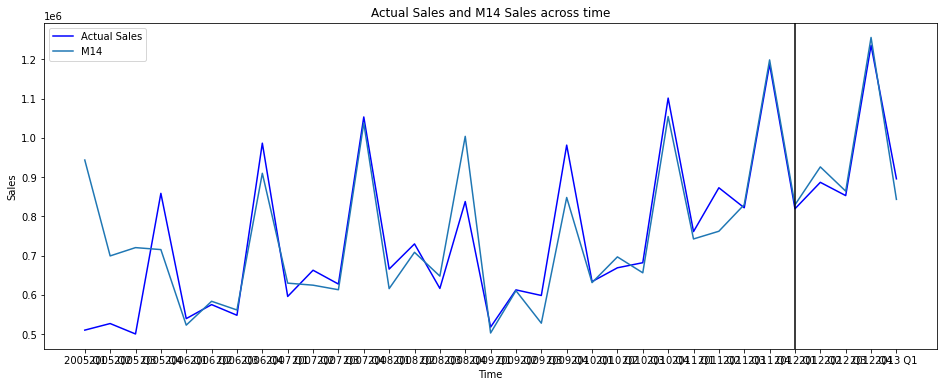

In [ ]:
# Plotting Time Series
plt.figure(figsize=(16,6))
plt.plot(df["Sales"], color='blue',label='Actual Sales')
plt.plot(train["M14"],label='M14')
plt.title("Actual Sales and M14 Sales across time")
plt.xlabel('Time')
plt.ylabel('Sales')
plt.axvline(x="2012 Q1", color="black")
plt.legend()
plt.show()

In [ ]:
# Calculate MAPE
acc = accuracy(actual=df["Sales"], predicted=train["M14"], h=4)
MAPE_df.iloc[13,0] = acc.iloc[0,0]
MAPE_df.iloc[13,1] = acc.iloc[1,0]
acc

,MAPE(%)
Training set,10.46
Testing set,3.31
